### GW tutorial bonus track: Antenna pattern and redshift horizon


Author: Melissa Lopez

Email: m.lopez@uu.nl

In [1]:
from pycbc.waveform import get_fd_waveform
from pycbc.cosmology import _redshift
import numpy as np
import pycbc.psd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

#### Network antenna patterns

For an L shape detector such as current Advanced LIGO and Advanced Virgo the output of the detector

$h(t) =  h_{+}(t)F_{+}(\theta, \phi, \psi) + h_{\times}(t)F_{\times}(\theta, \phi, \psi)$

where $F_{+}$ and $F_{\times}$ represent the antenna pattern defined as

$F_{+}(\theta, \phi, \psi) = \frac{1}{2}(1+ \cos^2{\theta}) \cos{2\phi}\cos{2\psi}  - \cos{\theta}\sin{2\phi}\sin{2\psi},$

$F_{\times}(\theta, \phi, \psi) = \frac{1}{2}(1+ \cos^2{\theta}) \cos{2\phi}\sin{2\psi}  - \cos{\theta}\sin{2\phi}\cos{2\psi}.$

Note that $\theta$ is the latitute and $\phi$ is the longitude that indicate the direction of propagation while $\psi$ is the polarization angle of the incoming gravitational wave.



**Excercise 1:** Return the antenna pattern factors $F_{+}$ and $F_{x}$ as a function of sky location and polarization angle for a hypothetical interferometer located at the north pole.

Angles are in radians. Declinations of $\pm \pi/2$ correspond to the normal to the detector plane (i.e. overhead and underneath) while the point with zero right ascension and declination is the direction of one of the interferometer arms.

Define a function `antenna_pattern_L` with parameters `theta, phi, psi ` that returns `f_plus` and `f_cross`


In [2]:
# Solution

def antenna_pattern_L(theta, phi, psi):

    f_plus  =  (1.0/2.0) * (1.0 + np.cos(theta) * np.cos(theta)) * \
                np.cos(2.0 * phi) * np.cos(2.0 * psi) - \
                np.cos(theta) * np.sin(2.0*phi) * np.sin(2.0 * psi)

    f_cross =   (1.0/2.0) * (1.0 + np.cos(theta)*np.cos(theta)) * \
                np.cos (2.0 * phi) * np.sin (2.0* psi) + \
                np.cos(theta) * np.sin(2.0*phi) * np.cos(2.0 * psi)
    return f_plus, f_cross

For a triangle Einstein Telescope it can be demonstrated (see [here](https://arxiv.org/pdf/1201.3563) Eq. 9 and 10) that with a $\pi/3$ opening angle for a single arm can be rewritten as

$F^{1}_{+}(\theta, \phi, \psi) = -\frac{\sqrt{3}}{4}[(1+ \cos^2{\theta}) \sin{2\phi}\cos{2\psi}  + 2\cos{\theta}\cos{2\phi}\sin{2\psi}],$

$F^{1}_{\times}(\theta, \phi, \psi) = \frac{\sqrt{3}}{4}[(1+ \cos^2{\theta}) \sin{2\phi}\sin{2\psi}  + 2\cos{\theta}\cos{2\phi}\cos{2\psi}].$

Note that the relation to the other two arms are:

$F^{2}_{+, \times}(\theta, \phi, \psi) = F^{1}_{+, \times}(\theta, \phi + 2\pi/3, \psi),$

$F^{3}_{+, \times}(\theta, \phi, \psi) =  F^{1}_{+, \times}(\theta, \phi - 2\pi/3, \psi).$

**Excercise 2:** Similarly to the previous exercise, return the antenna pattern factors $F_{+}$ and $F_{x}$.

Define a function `antenna_pattern_ET_1` with parameters `theta, phi, psi ` that returns `f_plus` and `f_cross`.

If the joint reponse is given by $F_{+, \times} = \sum^{3}_{A=1} F^{A}_{+, \times}$ can you write a function called `antenna_pattern_joint_ET` that returns `f_plus_joint` and `f_cross_joint`?


In [3]:
# Solution

def antenna_pattern_ET_1(theta, phi, psi):
    f_plus  =  -((3**0.5)/4) * ((1 + np.cos(theta) * np.cos(theta)) * \
                np.sin (2 * phi) * np.cos (2 * psi) + \
                2*np.cos(theta) * np.cos(2*phi) * np.sin (2 * psi))

    f_cross =   +((3**0.5)/4) * ((1 + np.cos(theta)*np.cos(theta)) * \
                np.sin(2.0 * phi) * np.sin(2 * psi)  - \
                2*np.cos(theta) * np.cos(2*phi) * np.cos(2 * psi))
    return f_plus, f_cross

def antenna_pattern_joint_ET(theta, phi, psi):
    f1_plus, f1_cross = antenna_pattern_ET_1(theta, phi, psi)
    f2_plus, f2_cross = antenna_pattern_ET_1(theta, phi + 2 * np.pi/3.0, psi)
    f3_plus, f3_cross = antenna_pattern_ET_1(theta, phi - 2 * np.pi/3.0, psi)

    F_plus = (f1_plus**2 + f2_plus**2 + f3_plus**2)
    F_cross = (f1_cross**2 + f2_cross**2 + f3_cross**2)
    return F_plus, F_cross

The full configuration of Einstein Telescope is still unknown but a triangle is not the only option. We hypothesize that

- A single 'L'

- 2 'L' rotated $3\pi/4$ with respect to each other

**Exercise 3:** Can you write down the functions `antenna_pattern_joint_ET_1L` and `antenna_pattern_joint_ET_2L_45deg`?

In [4]:
# Solution

def antenna_pattern_joint_ET_1L(theta, phi, psi):
    f1_plus, f1_cross = antenna_pattern_L(theta, phi, psi)
    F_plus = (f1_plus**2)
    F_cross = (f1_cross**2)
    return F_plus, F_cross 

def antenna_pattern_joint_ET_2L_45deg(theta, phi, psi):
    f1_plus, f1_cross = antenna_pattern_L(theta, phi, psi)
    f2_plus, f2_cross = antenna_pattern_L(theta, phi + 3* np.pi/4.0, psi)
    F_plus = (f1_plus**2 + f2_plus**2 )
    F_cross = (f1_cross**2 + f2_cross**2)
    return F_plus, F_cross 

For a gravitational wave from a binary, the signal depends on the inclination angle $\iota$. In particular, this contribution can be expressed as (see [here](https://arxiv.org/pdf/1201.3563) Eq. 23),

$\mathcal{F} = \sum_{A}[\frac{1}{4}(1 + \cos^2 \iota^2)(F_{+}^{A})^{2} + \cos^{2}\iota (F_{+}^{A})^{2}  ]$.

**Exercise 4:** Return $\mathcal{F}$ in a function called `antenna_pattern_joint_ET_binary` that needs these parameters `theta, phi, psi, iota, antenna_pattern`. Note that `antenna_pattern` is a function that will be specified later.


In [5]:
def antenna_pattern_ET_joint_binary(theta, phi, psi, iota, antenna_pattern):
    '''
    Returns F^2_rms, mean square antenna pattern avagring over inclination angle
    '''

    Fp, Fc =  antenna_pattern(theta, phi, psi) #antenna_pattern_joint_ET(theta, phi, psi)

    Fp_iota = (1/4.0)*((1 + np.cos(iota)**2)**2)* Fp
    Fc_iota =  (np.cos(iota)**2 )* Fc
    F = (Fp_iota + Fc_iota)
    return F

We want to compute the SNR distribution of a set of GW signals from equal mass binary black holes. From previous tutorials we learnt to generate waveforms with `get_fd_waveform` and compute the SNR timeseries with `matched_filter` functions. 

**Exercise 5:** Create a function `waveform_snrs` that generates a set of waveforms and computes their optimal SNR $(h_{+}|h_{+})$. You will need the following parameters.

_Hint_: You need to return the maximum of the real part of the SNR (a single value per waveform).

In [6]:
m1 = np.arange(0.5, 4000, 5)
m2 = m1
delta_f = 1.0/16.
dist = 1000
flow = 3
sample_rate = 8192.
flen = int(sample_rate/ (delta_f)) + 1

In [7]:
# Solution

def waveform_snrs(m1, m2, delta_f, dist, flow, sample_rate, psd):
    snrs = list()
    for i in range(len(m1)):
        hp, hc = get_fd_waveform(approximant="IMRPhenomD",
                          mass1=m1[i],
                          mass2=m2[i],
                          delta_f=delta_f ,
                          distance = dist,
                          f_lower=flow, f_final=sample_rate)

        snr = pycbc.filter.matched_filter(hp, hp, psd=psd,low_frequency_cutoff=flow)
        snrs.append(snr.data.real.max())
    snrs = np.array(snrs)
    return snrs

**Exercise 6:** Also, from previous tutorials we learnt to load PSDs. Load the Einstein Telescope PSD, called `PSD`, and remove badly behaved values

Text(0, 0.5, 'PSD $(1/\\sqrt{Hz})$')

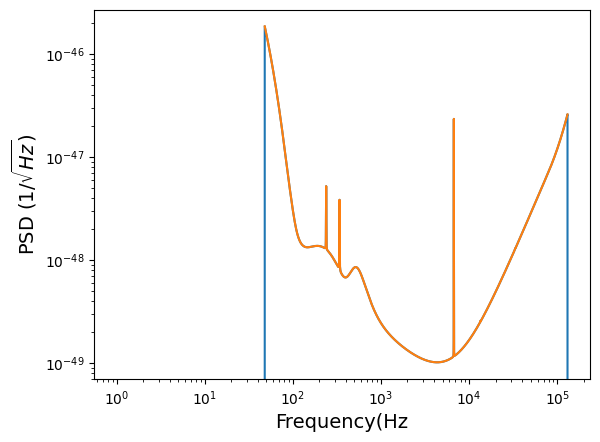

In [8]:
# Solution

PSD =  pycbc.psd.EinsteinTelescopeP1600143(flen, delta_f, flow) 
plt.loglog(PSD)
PSD.data[:int(flow/delta_f)] = np.inf
PSD.data[-1] = np.inf
plt.loglog(PSD)
plt.xlabel('Frequency(Hz', size = 14)
plt.ylabel(r'PSD $(1/\sqrt{Hz})$', size= 14)

# Network of detectors 

Here our aim is to study different possible configuration of Einstein Telescope

1. ET - triangle , arm length 10km `(label = 'ET triangle 10km')`

2. ET - single 'L' with 15 km arm length 15 km `(label = 'ET 1L 15km')`

3. ET - 2 'L's with 45^deg rotated w.r.t each other, arm length 7.5km `(label = 'ET 2L 7.5km')`

4. ET - 2 'L's with 45^deg rotated w.r.t each other, arm length 15km `(label = 'ET 2L 15km')`

We want to understand which configuration would have better sensitivity, so we plot the redshift of the hypothetically observed GW signal distribution as a function of the total mass.

In [9]:
# Some helper functions
def get_percentiles(thetas, phis, psi, iotas, antenna_pattern):
    """
    Calculate specified percentiles (10th, 50th, 90th) and the maximum value
    of the antenna pattern response for given input parameters.

    Args:
        thetas (list): List of theta angles.
        phis (list): List of phi angles.
        psi (float): Polarization angle.
        iotas (float): Inclination angle.
        antenna_pattern (callable): Function to compute the antenna pattern response.

    Returns:
        list: Percentiles [10th, 50th, 90th] and maximum value of the response.
    """
    Fs = list()
    for theta, phi in zip(thetas, phis):
        # Calculate the antenna pattern response for each (theta, phi) pair.
        F = antenna_pattern_ET_joint_binary(theta, phi, psi, iotas, antenna_pattern)
        Fs.extend(F)

    Fs = np.asarray(Fs)

    percentiles = list()
    for p in [10, 50, 90]:
        # Calculate specified percentiles of the responses.
        percentiles.append(np.percentile(Fs, p))

    # Append the maximum response value.
    percentiles.extend([max(Fs)])
    return percentiles

def horizon_distance(snrs, percentiles):
    """
    Compute the horizon distance of the detector based on signal-to-noise ratios (SNRs)
    and antenna pattern factors (percentiles of F_rms).

    Args:
        snrs (list or array): Signal-to-noise ratios.
        percentiles (list): Percentile values of F_rms (10%, 50%, 90%, max).

    Returns:
        list: Redshift values corresponding to the horizon distances.
    """
    redshifts = list()
    for p in percentiles:
        # Calculate redshift using the specified formula.
        redshifts.append(_redshift(snrs * p ** 0.5 * 1000 / 8.0))
    return redshifts

def interpolation(mass, total_mass, redshifts):
    """
    Interpolate redshift values as a function of mass and total mass.

    Args:
        mass (array): Array of mass values.
        total_mass (float): Total mass value for interpolation.
        redshifts (list): Redshift values to interpolate over.

    Returns:
        list: Interpolated redshift values for the total mass.
    """
    interpolations = list()
    for R in redshifts:
        # Perform cubic interpolation of redshift values.
        f = interp1d(mass / (1 + R), R, kind='cubic')
        R_interpolated = f(total_mass)
        interpolations.append(R_interpolated)
    return interpolations


In [10]:
# Parameters

# Random sky locations with null polarization
thetas = np.arccos(np.random.uniform(0, 1, 100))
phis = np.random.uniform(0, 2 * np.pi , 100)
iotas = np.arccos(np.linspace(-1, 1 , 100))
psi = 0

# Masses

mass = m1 + m2
total_mass = np.linspace(1, 1e3, 1000)

**Exercise 7:** Which ET configuration would be better according to these plots? 

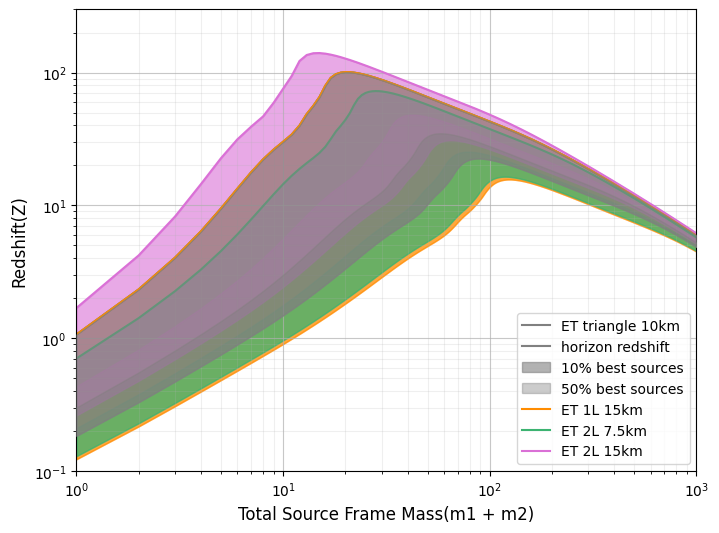

In [11]:
scales = [10, 15, 7.5, 15] # lenght of the arms
antenna_patterns = [antenna_pattern_joint_ET, antenna_pattern_joint_ET_1L,
                   antenna_pattern_joint_ET_2L_45deg,
                   antenna_pattern_joint_ET_2L_45deg ]
labels = ['ET triangle 10km', 'ET 1L 15km', 'ET 2L 7.5km', 'ET 2L 15km']
colors = ['grey', 'darkorange', 'mediumseagreen', 'orchid']

fig = plt.figure(figsize=(8, 6))
for scale, antenna_pattern, color, label in zip(scales, antenna_patterns, colors, labels): 
    # The PSD is defined for 10km so we rescale according to the lenght of the arms
    psd =  PSD * ((10.0/scale)**2)
    
    # We compute the antenna pattern and get 10, 50, 90 percentile and its maximum
    percentiles = get_percentiles(thetas, phis, psi, iotas, antenna_pattern)
    
    # We compute the SNR of the binary black hole population
    snrs = waveform_snrs(m1, m2, delta_f, dist, flow, sample_rate, psd)
    
    # We compute the redshift for the population and the given percentiles
    redshifts = horizon_distance(snrs, percentiles)
    
    # We interpolate for the total mass
    Rs = interpolation(mass, total_mass, redshifts)
    
    if color == 'grey':
        plt.loglog(total_mass, Rs[3], color=color, label=label)
        plt.loglog(total_mass, Rs[3], color=color, label='horizon redshift')
        plt.fill_between(total_mass , Rs[3],Rs[0],color=color,alpha=.6, label = '10% best sources', zorder=10)
        plt.fill_between(total_mass , Rs[0], Rs[1],color=color, alpha=.4, label = '50% best sources', zorder=10)
    else: 
        plt.loglog(total_mass, Rs[3], color=color, label=label)
        plt.fill_between(total_mass , Rs[3],Rs[0],color=color,alpha=.6)
        plt.fill_between(total_mass , Rs[0], Rs[1],color=color, alpha=.4)
    plt.ylabel('Redshift(Z)', size = 12)
    plt.xlabel('Total Source Frame Mass(m1 + m2)', size = 12)
    plt.ylim(0.1, 300)
    plt.xlim(1, 1e3)
    plt.grid(which='major', alpha=0.7)
    plt.grid(which='minor', alpha=0.2)
    plt.legend(fontsize=10)

You made it to the end of the tutorial including the bonus track. Impressive! I honestly do not have anything else for today, so you are all done. 

If you want we can still have a chat about GW data analysis!